In [29]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

import tensorflow
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

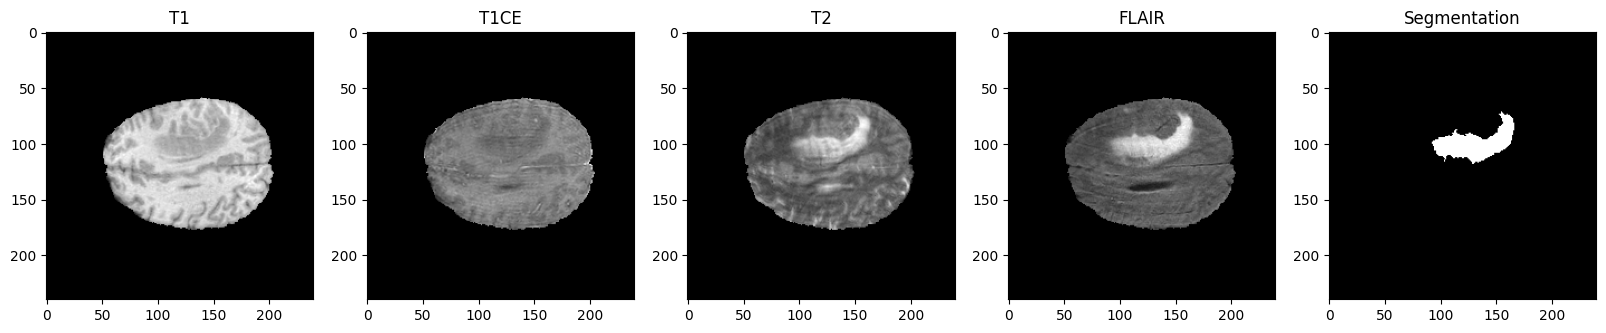

In [3]:
# Specify a sample path (update this path according to your local setup)
sample_path = '/home/jp/PycharmProjects/AI_Automatic_Tumor_Segmentation/DataBase/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img = nib.load(sample_path + 't1.nii')
t1ce_img = nib.load(sample_path + 't1ce.nii')
t2_img = nib.load(sample_path + 't2.nii')
flair_img = nib.load(sample_path + 'flair.nii')
seg_img = nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 MRI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
axs[0].imshow(t1_data[:, :, slice_nb], cmap='gray')
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:, :, slice_nb], cmap='gray')
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:, :, slice_nb], cmap='gray')
axs[2].set_title('T2')
axs[3].imshow(flair_data[:, :, slice_nb], cmap='gray')
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:, :, slice_nb], cmap='gray')
axs[4].set_title('Segmentation')
plt.show()

In [4]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)


(240, 240, 155)
(240, 240, 155)


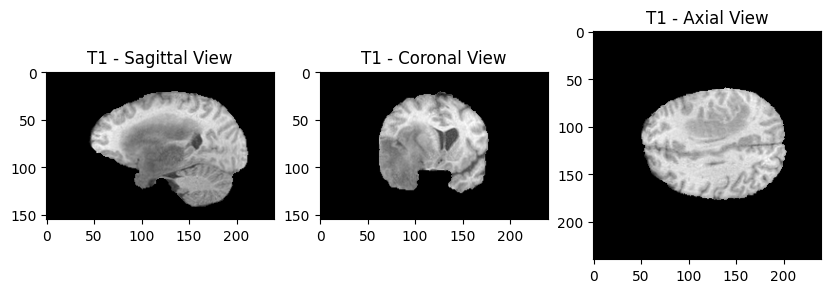

In [5]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

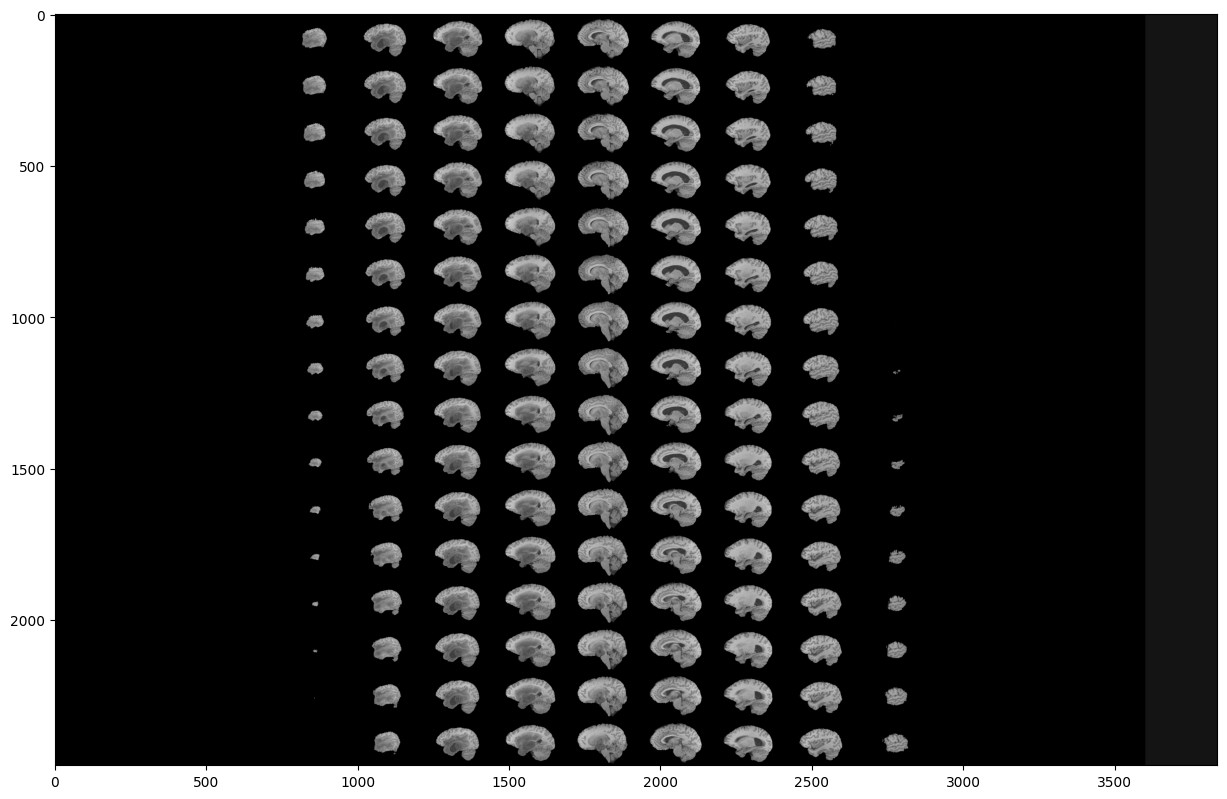

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

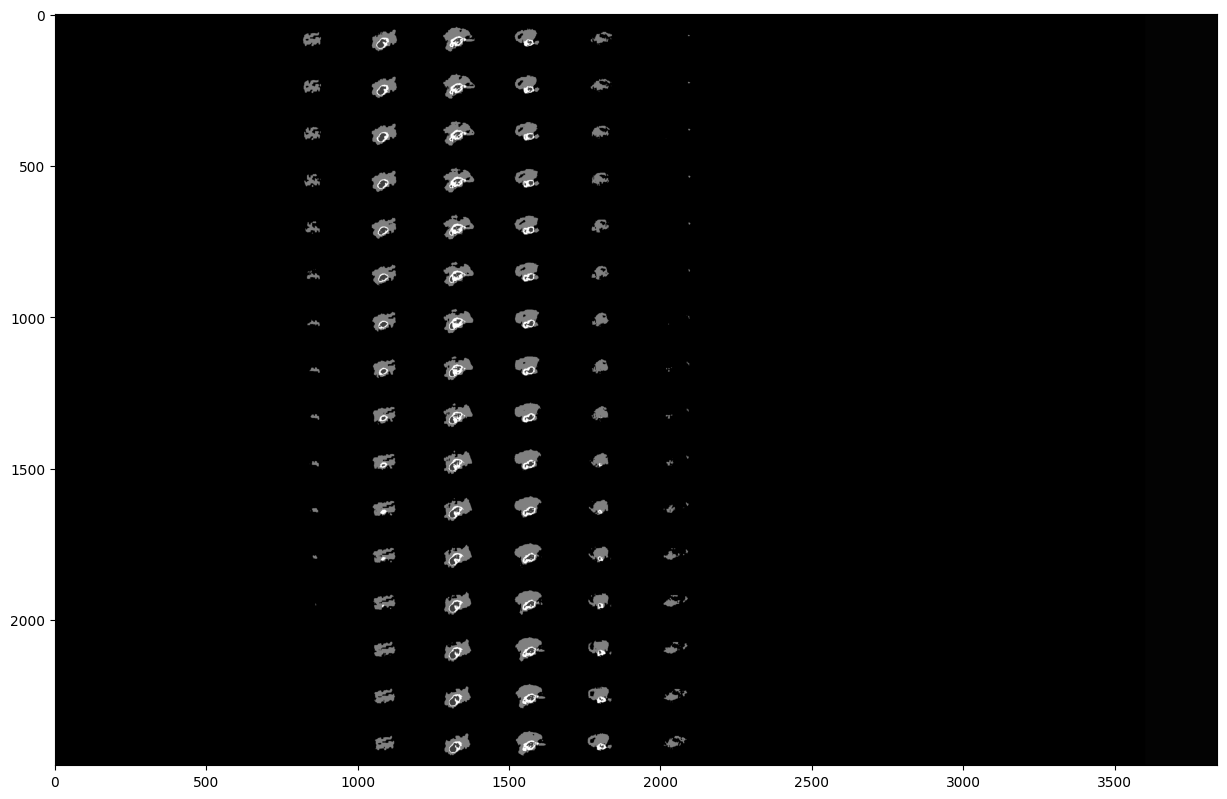

In [7]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

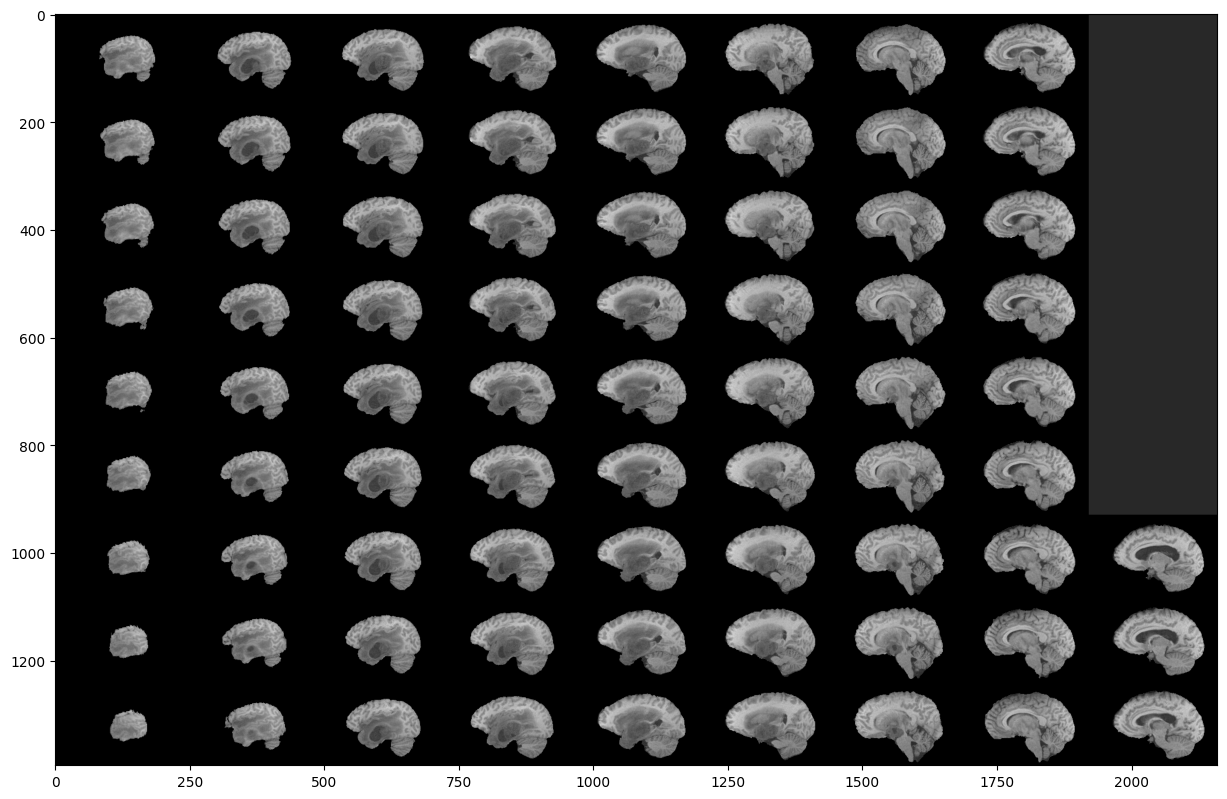

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

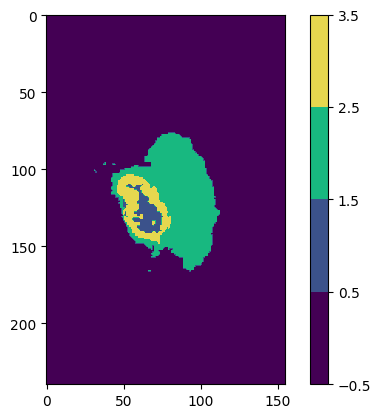

In [9]:
# Plot a segmantation
some_seg_img = nib.load("/home/jp/PycharmProjects/AI_Automatic_Tumor_Segmentation/DataBase/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [10]:
data_path = "/home/jp/PycharmProjects/AI_Automatic_Tumor_Segmentation/DataBase/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")


Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


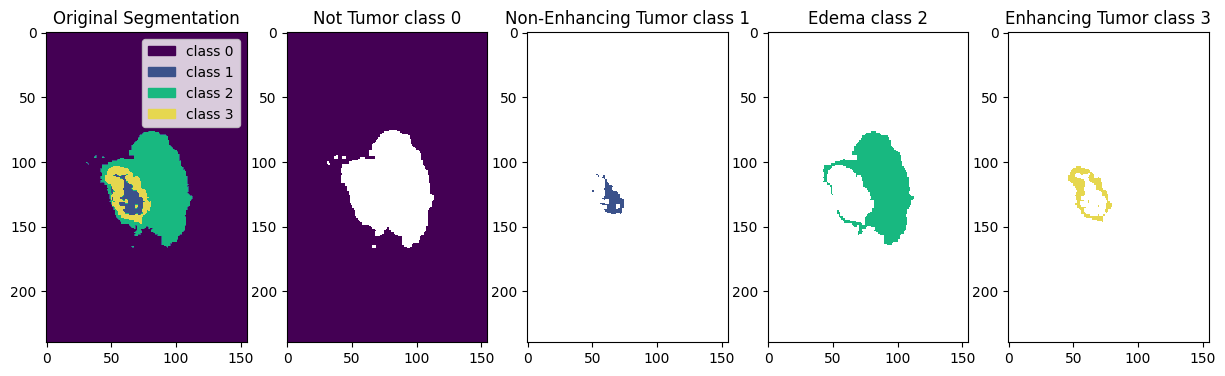

In [11]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [12]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

In [13]:
# Specify path of our BraTS2020 directory
data_path = "/home/jp/PycharmProjects/AI_Automatic_Tumor_Segmentation/DataBase/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [14]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [15]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [16]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [36]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# Métrica Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[..., i], [-1])
        y_pred_f = tf.reshape(y_pred[..., i], [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        total_loss += loss
    return total_loss / class_num

# Métrica de Precisión
def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_f, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

# Métrica de Sensibilidad (Recall)
def sensitivity(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Métrica de Especificidad
def specificity(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1 - y_true_f) * (1 - y_pred_f), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1 - y_true_f, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Parámetros
IMG_SIZE = 128
batch_size = 16

# Construcción del modelo
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)

# Compilación del modelo
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity
    ]
)

# Configuración de callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.000001,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    CSVLogger(
        'training.log',
        separator=',',
        append=False
    )
]

# Ajuste del modelo
model.fit(
    training_generator,
    epochs=35,
    steps_per_epoch=len(samples_train) // batch_size,
    callbacks=callbacks,
    validation_data=valid_generator
)


Epoch 1/35


I0000 00:00:1732559261.894868    5138 service.cc:148] XLA service 0x7f1c44036b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732559261.895031    5138 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-25 13:27:42.022896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732559262.446954    5138 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-25 13:28:26.971802: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 0

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9821 - dice_coef: 0.1911 - loss: 1.1432 - mean_io_u_5: 0.4570 - precision: 0.7407 - sensitivity: 0.5879 - specificity: 0.9952
Epoch 1: val_loss improved from inf to 0.12269, saving model to model_.01-0.122686.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9823 - dice_coef: 0.1929 - loss: 1.1130 - mean_io_u_5: 0.4537 - precision: 0.7509 - sensitivity: 0.6008 - specificity: 0.9952 - val_accuracy: 0.9813 - val_dice_coef: 0.2495 - val_loss: 0.1227 - val_mean_io_u_5: 0.2500 - val_precision: 0.9811 - val_sensitivity: 0.9764 - val_specificity: 0.9937 - learning_rate: 0.0010
Epoch 2/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9720 - dice_coef: 0.2515 - loss: 0.1784 - mean_io_u_5: 0.3307 - precision: 0.9716 - sensitivity: 0.9678 - specificity: 0.9906
Epoch 2: val_loss improved from 0.12269 to 0.09706, saving model to model_.02-0.097063.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9724 - dice

2024-11-25 13:32:56.225913: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-25 13:32:56.226076: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-25 13:32:56.226104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6762012437757786335
2024-11-25 13:32:56.226122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10220079036960277035
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 17: val_loss did not improve from 0.07307
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 910ms/step - accuracy: 0.9785 - dice_coef: 0.2766 - loss: 0.0840 - mean_io_u_5: 0.5652 - precision: 0.9784 - sensitivity: 0.9784 - specificity: 0.9928 - val_accuracy: 0.9813 - val_dice_coef: 0.2767 - val_loss: 0.0746 - val_mean_io_u_5: 0.5000 - val_precision: 0.9811 - val_sensitivity: 0.9811 - val_specificity: 0.9937 - learning_rate: 4.0000e-05
Epoch 18/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9806 - dice_coef: 0.2774 - loss: 0.0730 - mean_io_u_5: 0.4566 - precision: 0.9804 - sensitivity: 0.9805 - specificity: 0.9935
Epoch 18: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 18: val_loss did not improve from 0.07307
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9804 - dice_coef: 0.2778 - loss: 0.0737 - mean_io_u_5: 0.4504 - precision: 0.9802 - sensitivity: 0.9802 - specificity: 0.9934 - val_accuracy: 0.9813 - val_dice_coef: 0.2796 - val_loss: 0.0744 - val_mea

2024-11-25 13:37:13.744614: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-25 13:37:13.744668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6762012437757786335



Epoch 34: val_loss did not improve from 0.07307
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 960ms/step - accuracy: 0.9799 - dice_coef: 0.2765 - loss: 0.0782 - mean_io_u_5: 0.4489 - precision: 0.9797 - sensitivity: 0.9798 - specificity: 0.9933 - val_accuracy: 0.9813 - val_dice_coef: 0.2780 - val_loss: 0.0735 - val_mean_io_u_5: 0.5000 - val_precision: 0.9810 - val_sensitivity: 0.9811 - val_specificity: 0.9937 - learning_rate: 1.0000e-06
Epoch 35/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9753 - dice_coef: 0.2760 - loss: 0.0986 - mean_io_u_5: 0.4371 - precision: 0.9751 - sensitivity: 0.9751 - specificity: 0.9917
Epoch 35: val_loss did not improve from 0.07307
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9752 - dice_coef: 0.2763 - loss: 0.0987 - mean_io_u_5: 0.4323 - precision: 0.9749 - sensitivity: 0.9750 - specificity: 0.9917 - val_accuracy: 0.9813 - val_dice_coef: 0.2780 - val_loss: 0.0735 - val_mean_io_u_5: 0.5000 - val_precision: 0.9810 - val_sensitivity: 0.9811 - val_speci

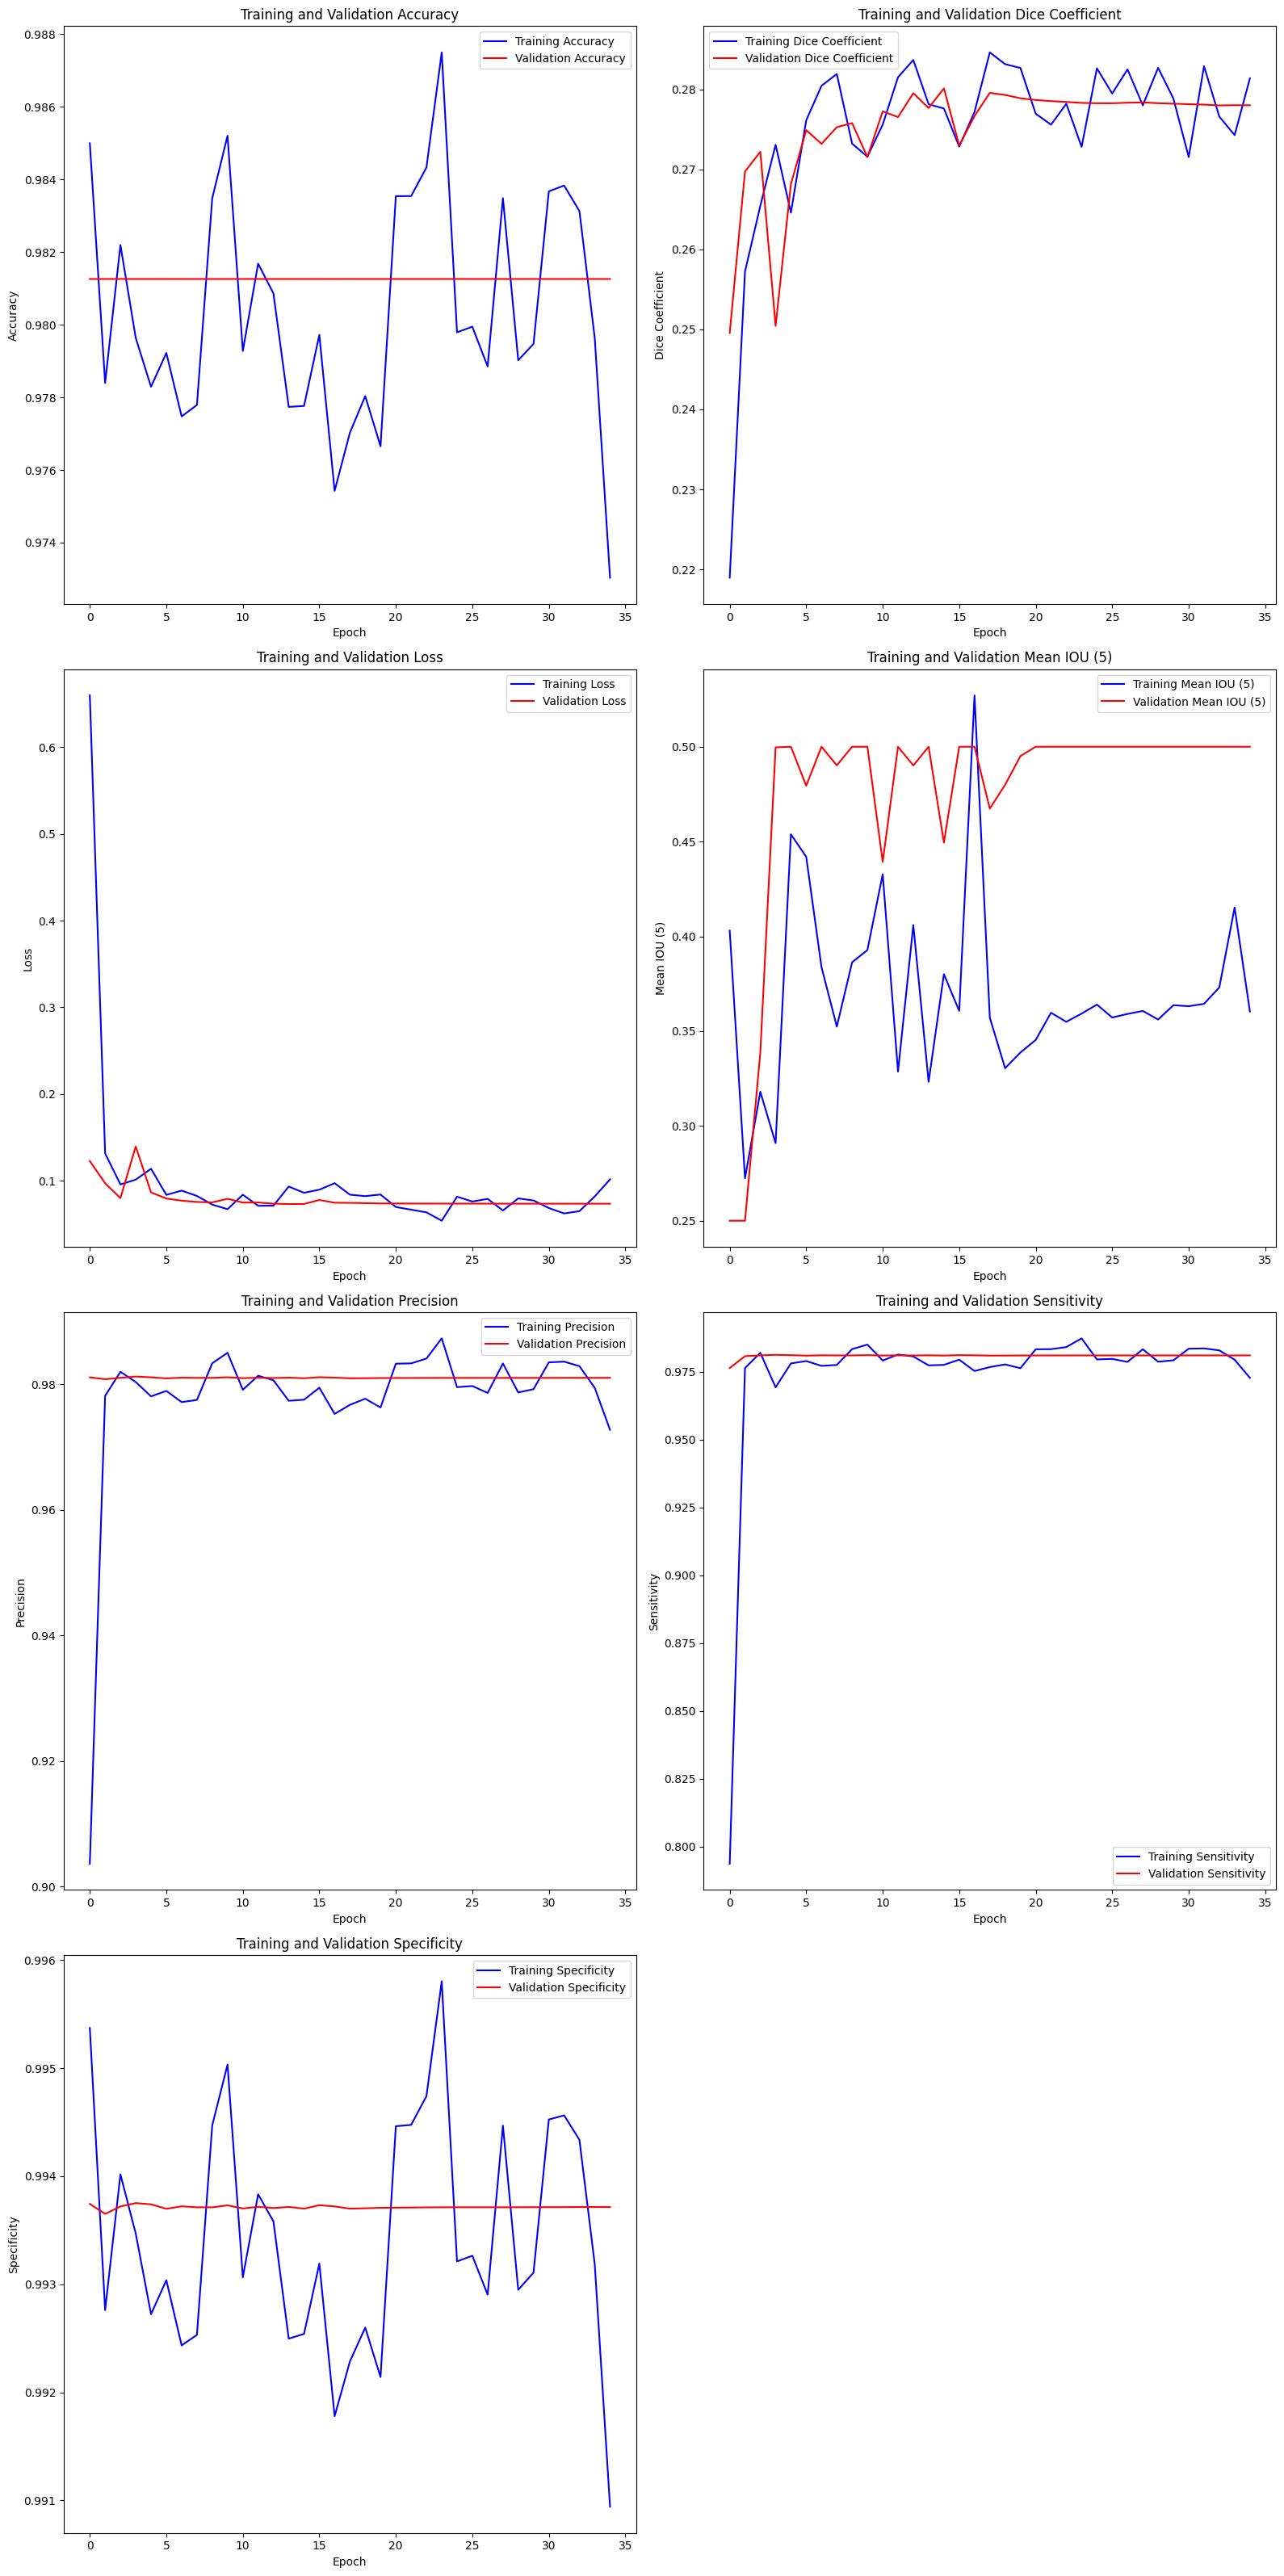

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos del archivo .log
log_file_path = '/modelos/unet/pesos/training.log'  # Actualiza esta ruta según sea necesario
history = pd.read_csv(log_file_path, sep=',')

# Preparar las figuras y sub-gráficos
fig, axs = plt.subplots(4, 2, figsize=(16, 32))

# Graficar las métricas de entrenamiento y validación
metrics = [
    "accuracy", "dice_coef", "loss", "mean_io_u_5",
    "precision", "sensitivity", "specificity"
]

# Configurar títulos para las gráficas
titles = [
    "Accuracy", "Dice Coefficient", "Loss", "Mean IOU (5)",
    "Precision", "Sensitivity", "Specificity"
]

for i, metric in enumerate(metrics):
    ax = axs[i // 2, i % 2]
    ax.plot(history['epoch'], history[metric], 'b', label=f'Training {titles[i]}')
    ax.plot(history['epoch'], history[f'val_{metric}'], 'r', label=f'Validation {titles[i]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(titles[i])
    ax.legend()
    ax.set_title(f'Training and Validation {titles[i]}')

# Hacer invisible el último sub-gráfico vacío si no se usa
axs[-1, -1].axis('off')

# Ajustar el layout de las figuras
plt.tight_layout()

# Mostrar la gráfica

In [34]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )




In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# Configuración de callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.000001,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    CSVLogger(
        'training.log',
        separator=',',
        append=False
    )
]


In [35]:
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/35


AttributeError: module 'keras.backend' has no attribute 'flatten'

In [51]:
# Intenta obtener un lote del generador de datos
training_batch = next(iter(training_generator))
validation_batch = next(iter(valid_generator))

print("Training batch:", training_batch[0].shape, training_batch[1].shape)
print("Validation batch:", validation_batch[0].shape, validation_batch[1].shape)

NameError: name 'tensorflow' is not defined

In [27]:
# Asegurarse de que el modelo está compilado
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Verificar el resumen del modelo
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 128, 128,  │        608 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_69[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_71[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_72[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_73[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_74[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_75[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 8, 8, 256) │          0 │ conv2d_76[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ conv2d_78[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 16, 16,    │          0 │ dropout_3[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 16, 16,    │    524,544 │ up_sampling2d_12

 Total params: 7,759,908 (29.60 MB)

 Trainable params: 7,759,908 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

NameError: name 'tensorflow' is not defined

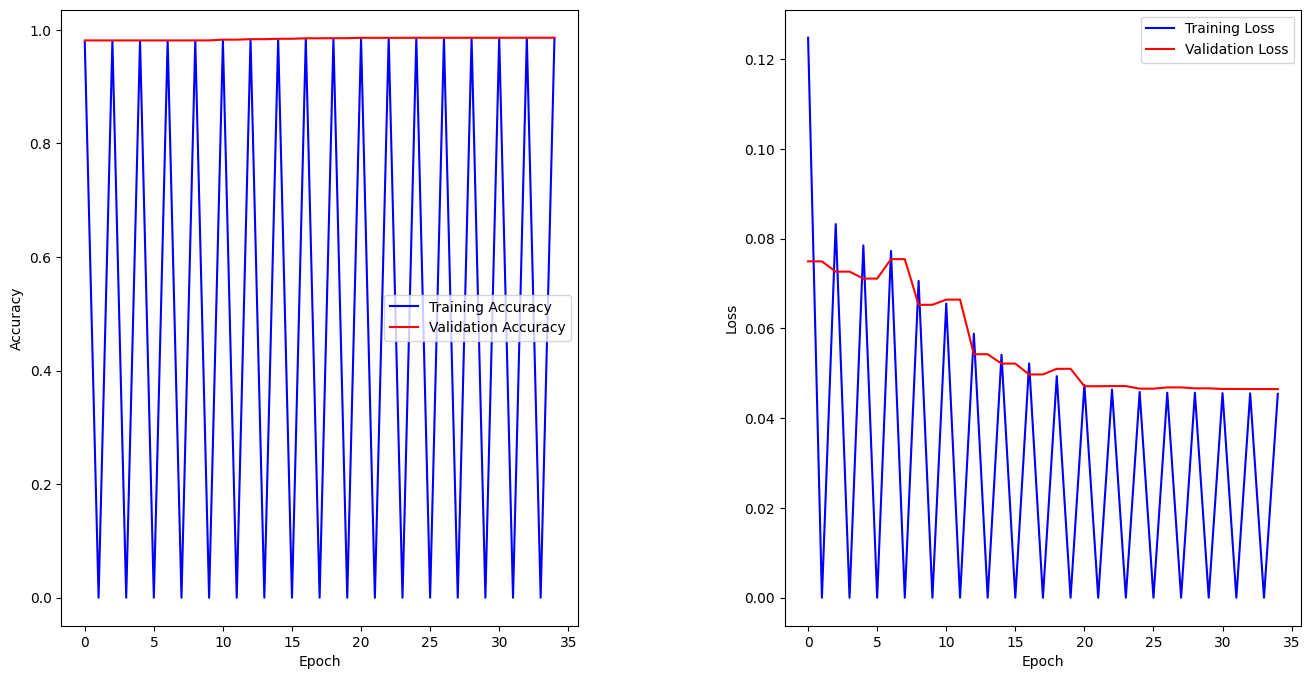

In [34]:


# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('pesos/training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()




# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

